In [62]:
import pandas as pd
import os
import re

def load_and_merge_data(folder_path, file_pattern=r'EPHC_(\d)_(\d{4})\.csv'):
    """
    Load all CSV files matching the pattern, extract specific columns,
    add year and trimester from filename, clean and convert income column,
    and merge into a single DataFrame.

    Parameters:
        folder_path (str): Path to folder containing CSV files.
        file_pattern (str): Regex pattern to extract trimester and year from filename.
                            Defaults to EPHC_[trimester]_[year].csv format.

    Returns:
        pd.DataFrame: Merged DataFrame with selected columns + year + trimester.
    """

    # Columns to load and their new names
    cols_to_load = {
        'P06': 'gender',
        'E01AIMDE': 'main_monthly_income',
        'anoest': 'years_of_study',
        'CATE_PEA': 'occupation_category'
    }

    all_data = []

    for filename in os.listdir(folder_path):
        match = re.match(file_pattern, filename)
        if match:
            trimester = int(match.group(1))
            year = int(match.group(2))
            filepath = os.path.join(folder_path, filename)

            # Load only necessary columns if they exist in the file
            try:
                df = pd.read_csv(filepath, delimiter=';', usecols=cols_to_load.keys(), low_memory=False)
            except ValueError:
                # Some files may be missing some columns; handle gracefully
                print(f"Warning: {filename} missing some columns. Trying to load existing ones.")
                df = pd.read_csv(filepath, delimiter=';', low_memory=False)
                df = df[[col for col in cols_to_load.keys() if col in df.columns]]

            # Rename columns
            df.rename(columns=cols_to_load, inplace=True)

            # Clean and convert 'main_monthly_income'
            if 'main_monthly_income' in df.columns:
                # Convert to string for replacement
                df['main_monthly_income'] = df['main_monthly_income'].astype(str)

                # Remove thousand separators (usually dots)
                df['main_monthly_income'] = df['main_monthly_income'].str.replace('.', '', regex=False)

                # Replace decimal commas with dots
                df['main_monthly_income'] = df['main_monthly_income'].str.replace(',', '.', regex=False)

                # Convert to numeric, coercing errors to NaN
                df['main_monthly_income'] = pd.to_numeric(df['main_monthly_income'], errors='coerce')

            # Add year and trimester columns
            df['year'] = year
            df['trimester'] = trimester

            all_data.append(df)

    # Concatenate all dataframes
    merged_df = pd.concat(all_data, ignore_index=True)
    return merged_df

# Example usage:
folder = '/content'  # replace with your folder path where CSV files are stored
merged_df = load_and_merge_data(folder)
merged_df.head()


,gender,main_monthly_income,occupation_category,year,trimester
0,6,0.000,,2024,3
1,1,2530301.124,2,2024,3
2,6,3192808.989,1,2024,3
3,1,0.000,,2024,3
4,6,0.000,,2024,3


<ipython-input-83-2861009675>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


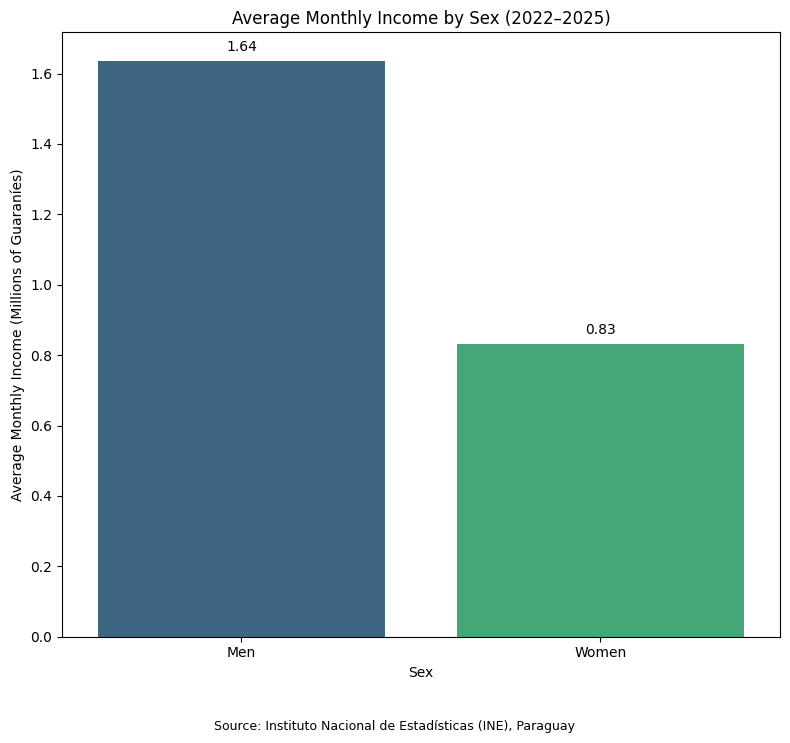

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter only rows where gender (sex) is 1 (men) or 6 (women)
filtered_df = merged_df[merged_df['gender'].isin([1, 6])]

# Group by sex and calculate average monthly income
income_by_sex = (
    filtered_df
    .groupby('gender')['main_monthly_income']
    .mean()
    .reset_index()
)

# Convert income to millions of Guaraníes
income_by_sex['main_monthly_income_millions'] = income_by_sex['main_monthly_income'] / 1_000_000

# Map gender codes to labels
sex_labels = {1: 'Men', 6: 'Women'}
income_by_sex['sex_label'] = income_by_sex['gender'].map(sex_labels)

# Plotting
plt.figure(figsize=(8, 7))
barplot = sns.barplot(
    data=income_by_sex,
    x='sex_label',
    y='main_monthly_income_millions',
    palette='viridis'
)

plt.title('Average Monthly Income by Sex (2022–2025)')
plt.xlabel('Sex')
plt.ylabel('Average Monthly Income (Millions of Guaraníes)')

# Add value labels on top of each bar
for p in barplot.patches:
    height = p.get_height()
    barplot.annotate(
        f'{height:.2f}',
        (p.get_x() + p.get_width() / 2, height),
        ha='center',
        va='bottom',
        fontsize=10,
        xytext=(0, 5),  # 5 points vertical offset
        textcoords='offset points'
    )

# Add data source footnote
plt.figtext(0.5, -0.05, 'Source: Instituto Nacional de Estadísticas (INE), Paraguay',
            wrap=True, horizontalalignment='center', fontsize=9)

plt.tight_layout()
plt.show()


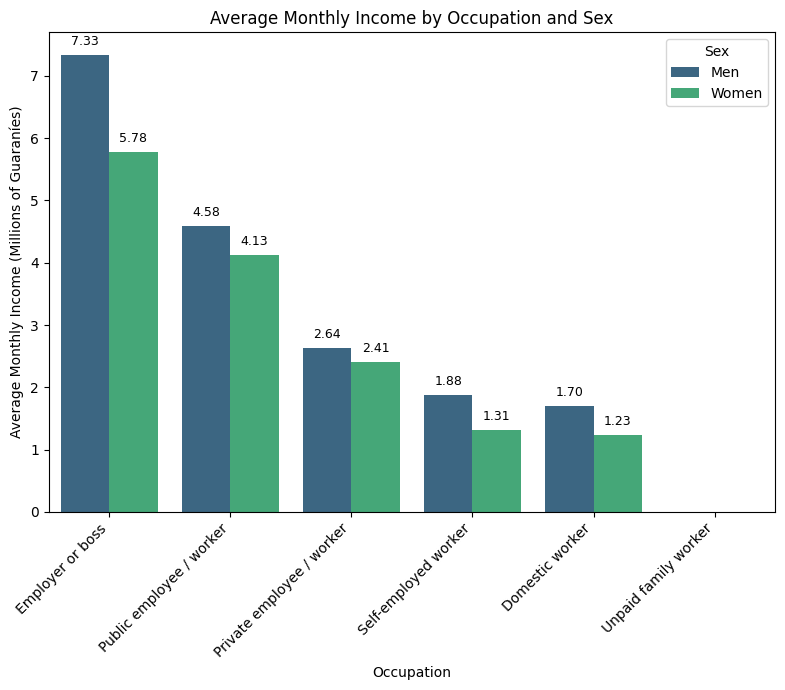

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns

# Occupation dictionary mapping codes to labels
occupation_map = {
    '1': 'Public employee / worker',
    '2': 'Private employee / worker',
    '3': 'Employer or boss',
    '4': 'Self-employed worker',
    '5': 'Unpaid family worker',
    '6': 'Domestic worker',
    # 'NA', 'Blanco', and 'NR' (code '9') will be excluded
}

# Filter only relevant genders
df_filtered = merged_df[merged_df['gender'].isin([1, 6])].copy()

# Convert occupation_category to string and clean
df_filtered['occupation_str'] = df_filtered['occupation_category'].astype(str).str.strip()

# Exclude blanks, NA, NR, and other unwanted codes
exclude_codes = ['Blanco', 'NA', '', 'nan', 'NaN', '9']
df_filtered = df_filtered[~df_filtered['occupation_str'].isin(exclude_codes)]

# Map occupation codes to labels
df_filtered['occupation_label'] = df_filtered['occupation_str'].map(occupation_map)

# Drop rows where mapping failed (unknown occupation codes)
df_filtered = df_filtered.dropna(subset=['occupation_label'])

# Map gender codes to labels
sex_labels = {1: 'Men', 6: 'Women'}
df_filtered['sex_label'] = df_filtered['gender'].map(sex_labels)

# Calculate order of occupations by overall average income
occupation_order = (
    df_filtered
    .groupby('occupation_label')['main_monthly_income']
    .mean()
    .sort_values(ascending=False)
    .index
    .tolist()
)

# Group by occupation and sex and calculate average income
income_by_occ_sex = (
    df_filtered
    .groupby(['occupation_label', 'sex_label'])['main_monthly_income']
    .mean()
    .reset_index()
)

# Convert income to millions of Guaraníes
income_by_occ_sex['income_millions'] = income_by_occ_sex['main_monthly_income'] / 1_000_000

# Optional: Remove zero or near-zero incomes to clean plot
income_by_occ_sex = income_by_occ_sex[income_by_occ_sex['income_millions'] > 0]

# Plotting
plt.figure(figsize=(8, 7))
barplot = sns.barplot(
    data=income_by_occ_sex,
    x='occupation_label',
    y='income_millions',
    hue='sex_label',
    palette='viridis',
    order=occupation_order
)

plt.title('Average Monthly Income by Occupation and Sex')
plt.xlabel('Occupation')
plt.ylabel('Average Monthly Income (Millions of Guaraníes)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sex')

# Add value labels on top of each bar, skipping zero-height bars
for p in barplot.patches:
    height = p.get_height()
    if height > 0.01:  # Skip tiny or zero bars
        barplot.annotate(
            f'{height:.2f}',
            (p.get_x() + p.get_width() / 2, height),
            ha='center',
            va='bottom',
            fontsize=9,
            xytext=(0, 5),  # vertical offset
            textcoords='offset points'
        )

plt.tight_layout()
plt.show()
